# An Analysis of the World Bank's Defining of Regions Based on Natural Resource Wealth

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets

%matplotlib notebook

The World Bank devides countries in many different ways into "regions" or "aggregates." Some of these are geographic, some are based on income, and many others. The point of splitting countries into groups is based on the assumption that the countries in a group are similar to each other in some ways and different from the countries that where placed into a different group. There are many different groups as there are many factors that countries can be split on.
<br>
This analysis is focused on the regions "Resource Rich Sub-Saharan Africa Countries" and "Non-Resource Rich Sub-Saharan Africa Countries." The region codes are `RRS` and `NRS` respectively. Sub-Saharan Africa is the only geographic region divided into these sub-categories. This is strange, as if there is really a difference between resource rich and non-resource rich countries, it shouldn't apply to only one area. In addition, currently these regions have been removed from the World Banks's databank webpage as well as the WDI download but they are still accessable through the API:

In [2]:
regions = ("NRS", "RRS")
data = pd.read_csv("WDIData.csv")
data[data["Country Code"].isin(regions)]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66


In [3]:
region_dfs = []
for region in regions:
    region_df = pd.read_xml(
        f"https://api.worldbank.org/v2/country?region={region}&per_page=1000&format=xml"
    )
    region_df["region"] = region
    region_dfs.append(region_df)

original_regions = pd.concat(region_dfs)
original_regions.drop_duplicates(subset="id", keep=False, inplace=True)
original_regions = original_regions.set_index("id")["region"]
original_regions.index.name = "Country Code"
countries = original_regions.index
print(countries)

Index(['BDI', 'BEN', 'BFA', 'CAF', 'CIV', 'CMR', 'COM', 'CPV', 'ERI', 'ETH',
       'GHA', 'GMB', 'GNB', 'KEN', 'LSO', 'MDG', 'MLI', 'MOZ', 'MWI', 'RWA',
       'SDN', 'SEN', 'SOM', 'STP', 'TGO', 'TZA', 'COD', 'COG', 'LBR', 'MRT',
       'NER', 'NGA', 'SLE', 'SSD', 'TCD', 'ZMB'],
      dtype='object', name='Country Code')


This analysis is split into two parts. First, I will try to see if the countries are split into "rich" and "non-rich" based on reasonable criteria. Then I will see if the spliting of the countries in this way leads to different results than a simple aggregation of all of the countries.

### How are the Countries split?

Three posibilities for grouping countries based on resources come to mind:
1. The total income from resources (`Total natural resources rents (% of GDP)`)
2. The percent of GDP that comes from resources (`Resource Product`)
3. The correlation between income from resources and GDP (`Resource Product - GDP Correlation`) <br><br>
Even though #3 is not a measure of resource wealth, it is a measure of how dependent the economy is on resources, which is  something that would make sense to group countries based upon.

In [4]:
posibilties = (
    "Total natural resources rents (% of GDP)",
    "Resource Product",
    "Resource Product - GDP Correlation",
)

To simplify the analyis I will be using the "enviroment" and "economy" themes, which are include `Total natural resources rents (% of GDP)` and `GDP`. I also included the "people" theme. I am using the `GDP (constant 2015 US$)` indicator instead of the `GDP (current US$)` indicator, because I want an indicator that is constant over time as I will be averaging and correlating all of the years together

In [5]:
themes = ["environment", "economy", "people"]
themes_dict = {}
for theme in themes:
    theme_df = pd.read_html(
        f"https://datatopics.worldbank.org/world-development-indicators/themes/{theme}.html"
    )[0]
    theme_df.columns = theme_df.columns.droplevel(0)
    themes_dict[theme] = theme_df[theme_df["Code"].str.contains("\.")].iloc[:, 0]

themes = themes_dict
themes_dict["economy"].iloc[-1] = "GDP (constant 2015 US$)"

In [6]:
indicators = np.concatenate(list(themes.values()))
data = data[
    data["Country Code"].isin(countries) & data["Indicator Name"].isin(indicators)
]
# Converting the data dataframe into wide form with the indicators as the columns
years = np.arange(1960, 2022).astype(np.str_)
melted = data.melt(
    id_vars=["Country Code", "Indicator Name"], value_vars=years, var_name="year"
)
melted["region"] = melted["Country Code"].replace(original_regions)
final_df = melted.pivot(
    index=["region", "Country Code", "year"], columns="Indicator Name", values="value"
)
final_df["Resource Product"] = (
    final_df["Total natural resources rents (% of GDP)"]
    * final_df["GDP (constant 2015 US$)"]
    / 100
)
final_df = final_df.dropna(subset="Resource Product")

We will use a bar chart to visualize the countries and their respective rankings for all of the possibilities mentioned above. In addition, the bars are colored based on their World Bank grouping.

In [7]:
mean_df = final_df.groupby(["region", "Country Code"]).mean()
mean_df["Resource Product - GDP Correlation"] = final_df.groupby(
    ["region", "Country Code"]
).apply(lambda df: df["GDP (constant 2015 US$)"].corr(df["Resource Product"]))

<IPython.core.display.Javascript object>


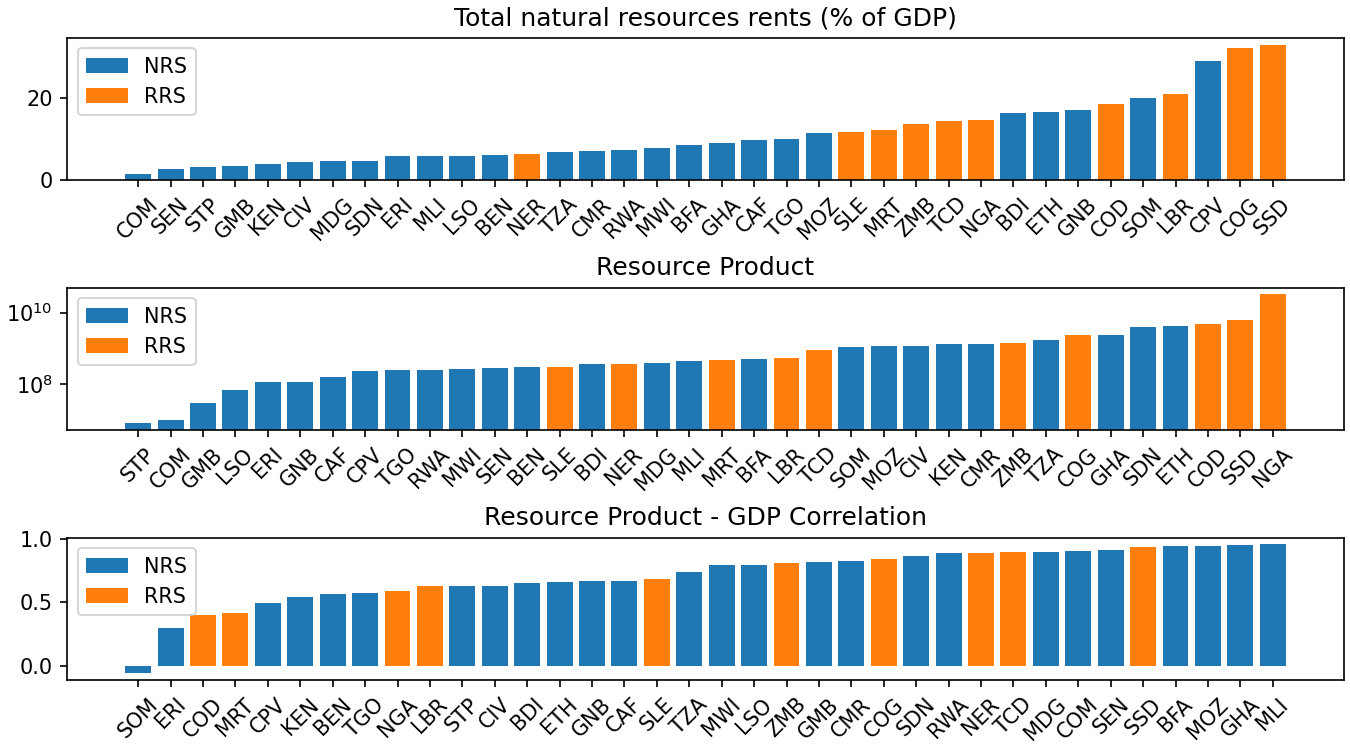

In [8]:
sorted_mean_list = []
fig, axs = plt.subplots(3, figsize=(9, 5), sharex=False, constrained_layout=True)

for indicator, ax in zip(posibilties, axs):
    sorted_mean = mean_df[indicator].sort_values().reset_index()
    sorted_mean_list.append(sorted_mean["Country Code"])
    for region in regions:
        this_df = sorted_mean.query("region == @region")
        ax.bar(this_df.index, this_df[indicator], label=region)
    ax.set_title(indicator)
    ax.set_xticks(sorted_mean.index, sorted_mean["Country Code"], rotation=45)
    if indicator == "Resource Product":
        ax.set_yscale("log")
    ax.legend()

In the top chart the `RRS` countries are mostly towards the higher numbers, but there are also many `NRS` countries in between. In addition, the chart rises steadily, with no big jumps between `NRS` and `RRS` so there is no logical place to split. The second chart has worse distribution, and also has no big jumps. The third chart is worst, with many `RRS` countries on the left side. If countries are grouped based on their resource wealth, this implies that this wealth has a strong effect on the economy. Therefore, last chart is particularly troubling, since this indicates that the group is a poor proxy for how much the resource revenue effects the economy.

The most reasonable possibilities for the groupings of `RRS` and `NRS`aren't correct. The criteria for the grouping must be something not so obvious. The other aggregates used by the World Bank are obvious, such as groupings by geographical reagon, GNI, or size. This itself indicates a serious issue with this grouping, even if the grouping actually works in practice.

### Comparing the World Bank grouping with other possibilities

Even a logical splitting of countries into groups must have a reason. The point of splitting data into groups is that different groups need different models to describe them. If the entire difference between the `RRS` and `NRS` countries is, for example, linearly based on resource wealth, they would be described by the same model, and there would be no need for two groups. I will create a heatmap that will show the correlation in each group, as well as the absolute value of the difference between the correlations of the groups. If there are significant difference between the correlations of the groups, that would indicate that the model is more comlicated than a simple linear model, and that the probably need to be split into groups.

As I showed in the last section, the way in which the World Bank grouped the countries is not the most intuitive. Therefore I will also create groupings based on the first two possibilities; the total income from resource rents and the percentage of GDP from resource rents. From the previous chart we can see that there is no obvious place split the countries, so I will use a multiverse analysis to show different possibilities. I will pick random countries for each group, biased towards the countries with larger values for both the total income and the percentage. I will use an animation to cycle through different choices so the reader will be able to get a general picture of a large range of potential choices.

In [9]:
# Nas are not distributed equally - many countries have many Nas.
# Therefore we will drop any columns with over 50% Nas.
subset = final_df.columns[(final_df.isna().sum() / len(final_df)) < 0.5]
# Next we will remove all indicators that measure a percent change, as we are not focused on the change of the values, rather on the values themselves
subset = [ind for ind in subset if "growth" not in ind]
themes = {k: np.intersect1d(subset, v) for k, v in themes.items()}
indicator_subset = ["Resource Product"]
[indicator_subset.extend(v) for v in themes.values()]
# Eliminate the duplicate values
indicator_subset = list(set(indicator_subset))
final_df.reset_index(inplace=True)

groups = ["Total natural resources rents (% of GDP)", "Resource Product"]
all_groups = ["Total natural resources rents (% of GDP)", "region", "Resource Product"]
all_regions = [*regions, "abs(Difference)"]
probs = mean_df[groups] / mean_df[groups].sum()
rng = np.random.default_rng(0)

In [10]:
def create_heatmap_df():

    heatmap_df = pd.DataFrame(
        index=indicator_subset,
        columns=pd.MultiIndex.from_product(
            [all_groups, all_regions], names=["group", "region"]
        ),
        dtype=float,
    )

    region_df = final_df.groupby("region").corr()["Resource Product"].unstack(0)
    region_df["abs(Difference)"] = region_df.diff(axis=1)["RRS"]
    heatmap_df["region"] = region_df

    return heatmap_df.dropna(how="all")


def redraw_heatmap(i, heatmap_df):

    for group in groups:

        heatmap_df = change_heatmap_df(group, heatmap_df)

    for theme, row in zip(themes, axs):
        for ax, region in zip(row, all_regions):

            im = ims[theme][region]
            im.set_data(heatmap_df.loc[themes[theme], (all_groups, region)])


def change_heatmap_df(group, heatmap_df):

    rrs = rng.choice(countries, 10, replace=False, p=probs[group])
    choices = np.where(final_df["Country Code"].isin(rrs), "RRS", "NRS")
    region_df = final_df.groupby(choices).corr()["Resource Product"].unstack(0)
    region_df["abs(Difference)"] = region_df.diff(axis=1)["RRS"].abs().clip(upper=0.5)
    heatmap_df[group] = region_df

    return heatmap_df

<IPython.core.display.Javascript object>


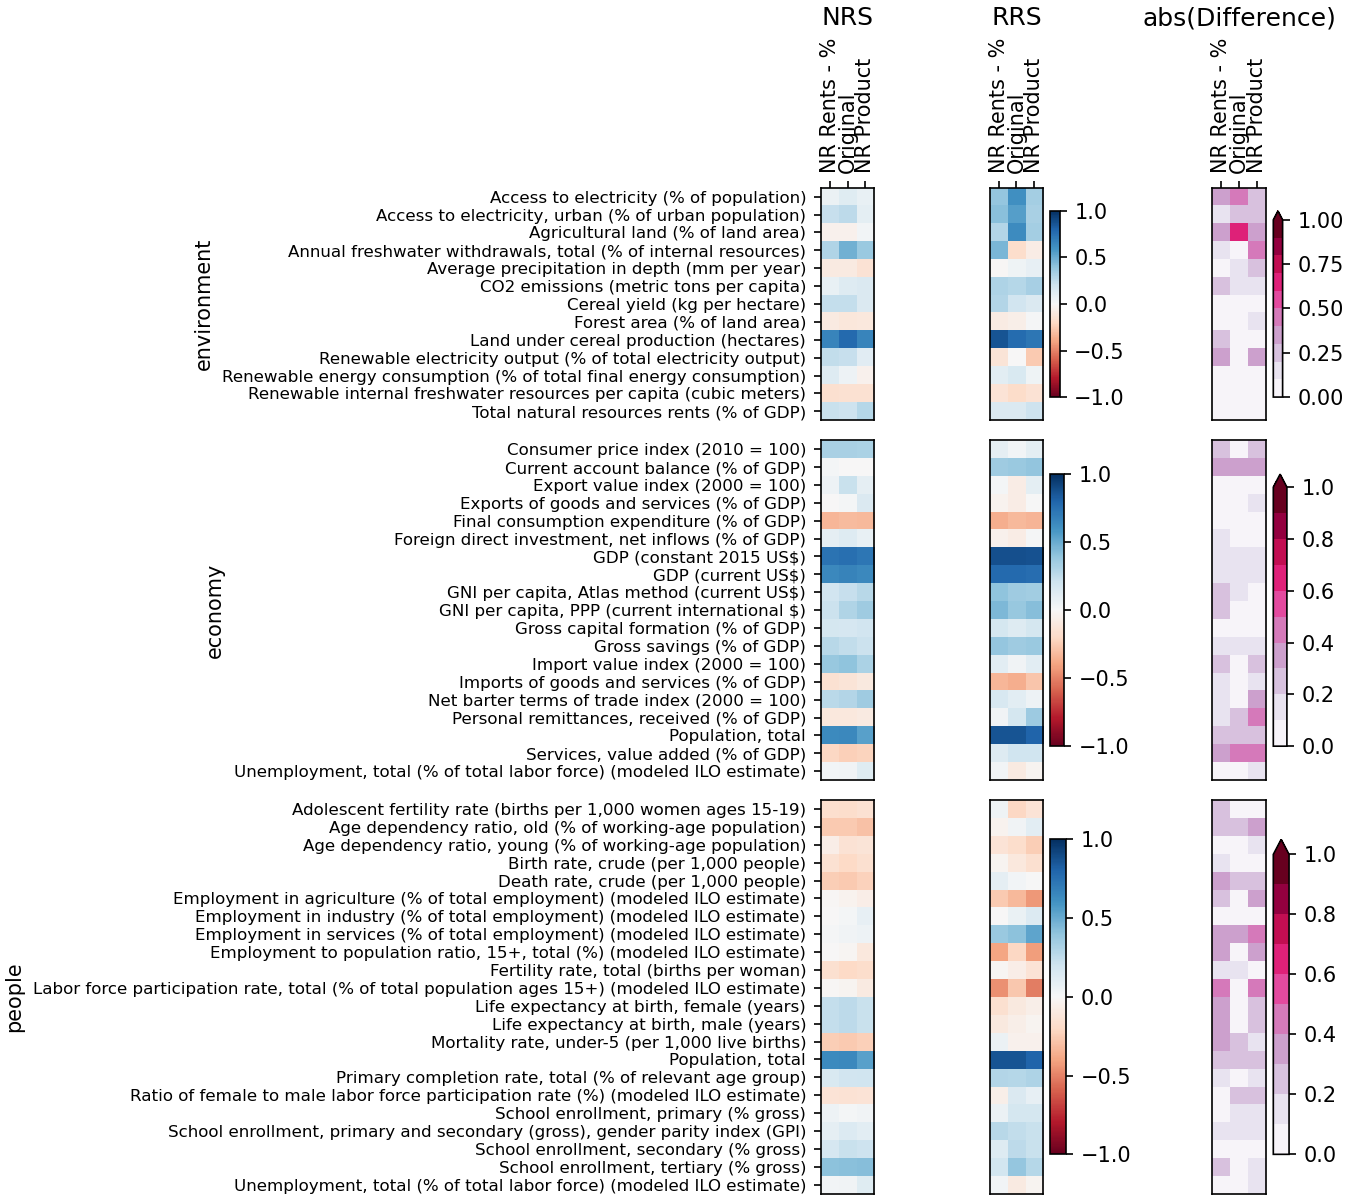

interactive(children=(Play(value=0, description='i', max=1000), Output()), _dom_classes=('widget-interact',))

In [11]:
heatmap_df = create_heatmap_df()

ims = {}
fig, axs = plt.subplots(
    len(themes),
    3,
    figsize=(9, 8),
    constrained_layout=True,
    gridspec_kw={"height_ratios": [len(v) for v in themes.values()]},
)
top_plot = True
for theme, row in zip(themes, axs):

    ims[theme] = {}
    left_plot = True

    for ax, region in zip(row, all_regions):

        ax.xaxis.tick_top()

        if region in regions:

            im = ax.imshow(
                heatmap_df.loc[themes[theme], (all_groups, region)],
                cmap="RdBu",
                vmax=1,
                vmin=-1,
            )

            if not left_plot:
                plt.colorbar(im, ax=ax, shrink=0.8)

        else:

            im = ax.imshow(
                heatmap_df.loc[themes[theme], (all_groups, region)],
                cmap=plt.get_cmap("PuRd", 10),
                vmax=1,
                vmin=0,
            )
            cb = plt.colorbar(im, ax=ax, shrink=0.8, extend="max")

        ims[theme][region] = im

        if left_plot:

            ax.set_yticks(np.arange(len(themes[theme])), labels=themes[theme], size=8)
            ax.set_ylabel(theme)
            left_plot = False

        else:

            ax.set_yticks([])

        if top_plot:

            ax.set_title(region)
            ax.set_xticks(
                (0, 1, 2), ("NR Rents - %", "Original", "NR Product"), rotation=90
            )

        else:

            ax.set_xticks([])

    top_plot = False

play = ipywidgets.Play(max=1000)
ipywidgets.interact(redraw_heatmap, i=play, heatmap_df=ipywidgets.fixed(heatmap_df));

From this visualization we can see that the splitting based on `Resource Product` leads to pretty similar results as the World Bank's grouping. We also see that the World Bank's grouping does not require seperate models for each group, indicating that that grouping does not have practical use. The `Total natural resources rents (% of GDP)` grouping results in the most different models, but this is not necessarily a good thing, as splitting data has its own pitfalls if not done correctly. 

### Conclusion

The World Bank's grouping of Sub-Sahara African countries into "Resource Rich" and "Non-Resource Rich" countries should not be used, as it is unclear what this grouping is actually based on and it does not correctly divide the countries in a useful way. If such a grouping is needed, I would recommend grouping by `Resource Product`or `Total natural resources rents (% of GDP)`, but this also comes with reservations, as further analysis is needed to see if countries should be grouped by resource wealth at all.